# **Malicious URLs Classification**
**Team members:**

**Yousra Houacine**   &   **Ikram Kadri** 


This notebook is part of a Machine Learning project for the academic year 2024/2025.  
The goal is to build a binary classifier that detects whether a given URL is **benign** or **malicious**.

##  Dataset

-  Source: [Kaggle – Malicious URLs Dataset](https://www.kaggle.com/datasets/naveenbhadouria/malicious)
-  Total URLs: 651,191
-  Features: only raw URLs and original label
-  Classes: `benign`, `phishing`, `defacement`, `malware` → transformed into `benign` and `malicious`

---

##  Objectives of this notebook

- Load and explore the dataset
- Analyze the class distribution
- Engineer basic URL-based features
- Prepare the data for machine learning models


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file containing raw URLs and their labels
df = pd.read_csv("../data/malicious_phish1.csv")

# Display dataset shape and column names
print("Shape:", df.shape)
print("\nColonnes:", df.columns)

# Show the first few rows of the dataset
df.head()


Shape: (651191, 2)

Colonnes: Index(['url', 'type'], dtype='object')


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
# Check if there are any missing values in the dataset.
# This helps ensure data quality before proceeding with feature engineering or model training.

df.isnull().sum()


type
benign        0.657415
defacement    0.148124
phishing      0.144521
malware       0.049939
Name: proportion, dtype: float64

## Convert multiclass labels to binary labels

The original class distribution is **highly imbalanced**, with `benign` representing over 65% of the data, while `malware` and others are underrepresented.

To simplify the classification task and reduce issues caused by class imbalance, we merge all attack-related categories — `phishing`, `defacement`, and `malware` — into a single class: **malicious**.

This turns the problem into a **binary classification task**:
- `benign` → safe
- `malicious` → any harmful URL

This strategy improves model training stability, reduces bias toward the majority class, and better reflects real-world cybersecurity needs (i.e., is the URL dangerous or not).


label
benign       428103
malicious    223088
Name: count, dtype: int64


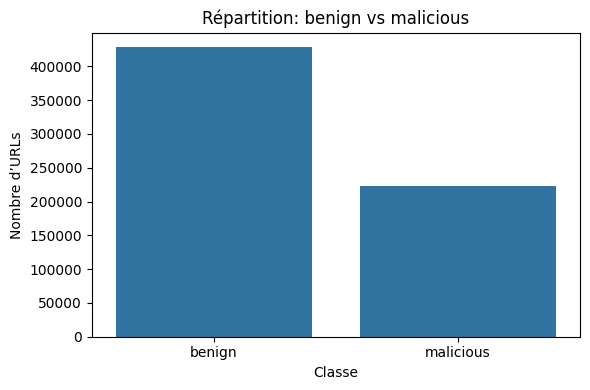

In [ ]:
# Group the original classes into two: 'benign' vs 'malicious'
# If the original type is 'benign', keep it; otherwise, label it as 'malicious'
df['label'] = df['type'].apply(lambda x: 'benign' if x == 'benign' else 'malicious')

# Check the distribution of the new binary labels
print(df['label'].value_counts())

# Visualize the class distribution using a bar plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title('Distribution: benign vs malicious')
plt.xlabel('Class')
plt.ylabel('Number of URLs')
plt.tight_layout()
plt.show()


##  Feature Extraction from URLs

Before training any machine learning model, we must transform the raw URL text into meaningful **numerical features**.

The goal is to capture characteristics of each URL that may help distinguish between **benign** and **malicious** links.

The following features are extracted:

- `url_length` : total number of characters in the URL
- `num_digits` : how many digits (0-9) appear in the URL
- `num_special_chars` : number of special characters (e.g., `@`, `-`, `=`, `!`)
- `num_dots` : number of dots `.` (usually indicates subdomains)
- `num_subdirs` : number of slashes `/` (may indicate deep paths)
- `has_ip` : 1 if the URL contains an IP address instead of a domain name
- `has_https` : 1 if the URL starts with `https` (considered more secure)

These features are then stored in a new DataFrame called `features_df`, along with the binary label:
- `0` → benign
- `1` → malicious

In [ ]:
import numpy as np
import re

# Extract the URLs from the original dataframe and ensure they're strings
urls = np.array(df['url'].astype(str).tolist(), dtype=str)

# Feature engineering: extract various characteristics from each URL
url_length = np.char.str_len(urls)  # Total number of characters in the URL
num_digits = np.array([sum(c.isdigit() for c in url) for url in urls])  # Count of numeric characters
num_special_chars = np.array([len(re.findall(r'[^\w\s]', url)) for url in urls])  # Count of special characters (e.g. !, @, /)
num_dots = np.char.count(urls, '.')  # Count of dots '.'
num_subdirs = np.char.count(urls, '/')  # Count of slashes '/'
has_ip = np.array([1 if re.search(r'\d+\.\d+\.\d+\.\d+', url) else 0 for url in urls])  # 1 if URL contains an IP address
has_https = np.char.startswith(urls, 'https').astype(int)  # 1 if URL starts with HTTPS

# Combine all features into a new DataFrame for further analysis or model input
features_df = pd.DataFrame({
    'url_length': url_length,
    'num_digits': num_digits,
    'num_special_chars': num_special_chars,
    'num_dots': num_dots,
    'num_subdirs': num_subdirs,
    'has_ip': has_ip,
    'has_https': has_https,
    'label': df['label'].map({'benign': 0, 'malicious': 1})  # Convert labels to numeric: 0 for benign, 1 for malicious
})


In [ ]:
# Save the extracted features and labels to a CSV file for later use (e.g., in model training)
features_df.to_csv("../data/features_dataset.csv", index=False)


## Feature Dataset Created

The new dataset has been successfully saved as `features_dataset.csv`.  
It contains a set of **engineered features** extracted from the raw URLs, which are useful for machine learning classification.

